# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.sample(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
584463,-1,3,1,6.0,3,4,3,5,5,3,4,0,5.0,0,-1,0.0,0.0,0.0,0.0,5.0,2.0,0,0,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
715710,1,4,1,3.0,5,1,5,1,1,2,5,1951,1.0,1,1,13.0,3.0,1.0,1.0,10.0,5.0,1,6,5.0,6,4,5,6,6,7,3,6,1,3,3,1,1,1,0,0.0,0.0,1,3,0.0,1.0,0.0,2.0,NaN,6.0,9.0,1.0,0.0,1.0,4.0,1992.0,W,3.0,2,2D,14,3.0,1.0,0.0,0.0,1.0,5.0,6.0,3.0,4.0,5.0,1.0,5.0,2.0,1.0,388.0,3.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,4.0,1.0
73736,2,4,1,3.0,3,1,5,1,1,5,6,1939,11.0,0,2,6.0,2.0,1.0,1.0,1.0,1.0,1,3,5.0,6,4,3,4,6,5,3,4,1,3,3,3,2,2,0,0.0,0.0,1,3,9.0,1.0,0.0,5.0,4.0,6.0,9.0,7.0,0.0,1.0,2.0,1992.0,O,4.0,8,8A,51,0.0,0.0,3.0,0.0,3.0,2.0,1.0,6.0,2.0,4.0,4.0,1.0,4.0,6.0,437.0,1.0,4.0,3.0,1.0,3.0,4.0,3.0,4.0,9.0,3.0
427287,3,2,2,2.0,4,1,5,2,1,4,6,1948,7.0,1,2,12.0,3.0,1.0,1.0,9.0,4.0,1,6,5.0,3,5,7,7,5,6,5,5,7,4,7,7,7,7,1,0.0,0.0,1,1,11.0,1.0,0.0,5.0,NaN,6.0,9.0,1.0,0.0,1.0,4.0,1993.0,W,3.0,8,8C,54,1.0,1.0,0.0,0.0,0.0,5.0,7.0,5.0,4.0,4.0,4.0,3.0,2.0,5.0,599.0,3.0,3.0,1.0,0.0,1.0,3.0,4.0,4.0,7.0,5.0
793200,-1,1,2,3.0,1,5,2,5,5,4,1,0,9.0,1,3,33.0,11.0,11.0,5.0,7.0,3.0,1,15,1.0,1,4,4,4,1,2,2,3,6,7,7,4,6,6,2,0.0,0.0,2,5,20.0,4.0,1.0,3.0,NaN,2.0,9.0,2.0,1.0,8.0,5.0,1992.0,W,3.0,2,2D,14,2.0,2.0,1.0,0.0,0.0,3.0,3.0,3.0,5.0,4.0,2.0,3.0,3.0,2.0,1111.0,4.0,2.0,0.0,0.0,1.0,5.0,5.0,2.0,5.0,1.0


In [6]:
# Looks like we have some null values, so it would be useful to know how many:

azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

What seems likely is that the dataset was amalgamated from various sources, and the sources varied in terms of which variables they had recorded. Looks like the columns come in various categories:

1. Where all rows have data - AGER_TYP, ALTERSKATEGORIE_GROB, etc.
2. Where 4854 rows have missing data - CJT_GESAMTTYP, GFK_URLAUBERTYP, etc.
And so on for:
3. 73499 rows have missing data
4. 93148 rows
5. 93740 rows
6. 97216 rows
7. 98979 rows 
8. 116515 rows
9. 121196 rows
10  133324 rows

Then there are missing values for HH_EINKOMMEN_SCORE (18348), KONSUMNAEHE (73969), GEBAEUDETYP_RASTER (93155), ANZ_HH_TITEL (97008), KBA13_ANZAHL_PKW (105800), W_KEIT_KIND_HH (107602), and KK_KUNDENTYP (584612).

Anyway, we'll come back to missing data shortly. Let's have a look at the feature summary data:

In [7]:
feat_info.shape

(85, 4)

In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


The dataset is structured with person-level information first, then household, building, postcode, neighbourhood, and finally community level information. There is a mixture of all kinds of data types.

It looks as though we have codes -1, 0, 9, or XX that are all being used for missing or unknown data. Looking at the Data_Dictionary.md file, these are indeed simply different ways that 'unknown' or 'missing' are coded from variable to variable.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Convert the missing_or_unknown column to lists
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.strip('[]').str.split(',')
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [11]:
# Identify missing or unknown data values and convert them to NaNs.
for i in range(0,85):
    azdias.loc[
        azdias.iloc[:, i].isin(feat_info.iloc[i]['missing_or_unknown']),
        azdias.columns[i]] = np.nan
    
# Check - we should have a lot more nulls now:
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

azdias.isnull().sum().sort_values(ascending=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

#### Discussion 1.1.2: Assess Missing Data in Each Column

As can be discerned from the above list, there are six columns that stand out particularly in terms of how much missing data they have:

* TITEL_KZ (889061 null values) is a flag for if someone has an academic title (Dr, Prof, etc.), and the vast majority (99.75%) of Germans in the dataset are not indicated as having one - 889061. 
* AGER_TYP (685843 null values) appears to be a sociological categorisation of mature consumers into passive elderly consumers, cultural elderly consumers, and experience-driven elderly consumers. There is no categorisation for 77.0% of the Germans in the dataset.
* KK_KUNDENTYP (584612 null values) is a category for a customer's pattern of behaviour over the past 12 months. Data are missing for 65.6% of the people in the dataset.
* KBA05_BAUMAX (476524 null values) is about the most common building type in the 'RR3 microcell' (an address sub-unit) the person resides at. 53.5% are null here.
* GEBURTSJAHR (392318 null values) is year of birth, and 44.0% are missing. 
* ALTER_HH (310267 null values) is a categorical value for the birthdate for the head of the household. 34.8% are missing.

These 6 columns will be removed from the dataset entirely.

In [13]:
# Investigate patterns in the amount of missing data in each column.
azdias[azdias['REGIOTYP'].isnull()].isnull().sum()/azdias.isnull().sum().sort_values(ascending=False)


AGER_TYP                 0.203568
ALTERSKATEGORIE_GROB     0.102048
ALTER_HH                 0.308264
ANREDE_KZ                     NaN
ANZ_HAUSHALTE_AKTIV      0.941332
ANZ_HH_TITEL             0.964518
ANZ_PERSONEN             1.000000
ANZ_TITEL                1.000000
ARBEIT                   0.959897
BALLRAUM                 0.994378
CAMEO_DEUG_2015          0.957746
CAMEO_DEU_2015           0.957746
CAMEO_INTL_2015          0.957746
CJT_GESAMTTYP            0.111660
EWDICHTE                 0.994378
FINANZTYP                     NaN
FINANZ_ANLEGER                NaN
FINANZ_HAUSBAUER              NaN
FINANZ_MINIMALIST             NaN
FINANZ_SPARER                 NaN
FINANZ_UNAUFFAELLIGER         NaN
FINANZ_VORSORGER              NaN
GEBAEUDETYP              1.000000
GEBAEUDETYP_RASTER       0.999968
GEBURTSJAHR              0.259825
GFK_URLAUBERTYP          0.111660
GREEN_AVANTGARDE              NaN
HEALTH_TYP               0.689431
HH_EINKOMMEN_SCORE       1.000000
INNENSTADT    

It tends to be the same rows that are featuring over and over again in terms of having missed data. Just by picking out the rows where REGIOTYP is null, for instance, will automatically identify all rows with nulls for MIN_GEBAEUDEJAHR, OST_WEST_KZ, SOHO_KZ, ANZ_PERSONEN, ANZ_TITEL, HH_EINKOMMEN_SCORE, WOHNDAUER_2008, GEBAEUDETYP, KKK, and WOHNLAGE. 

This can be seen if we plot a bar chart showing the frequency of the sort of rows we're talking about:

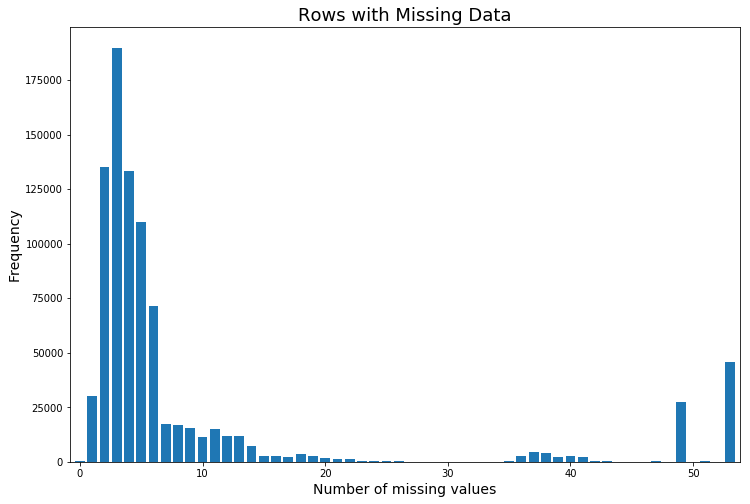

In [14]:
dftemp = azdias.isnull().sum(axis=1).value_counts().sort_index()
plt.figure(figsize=(12,8))
plt.bar(x=dftemp.index, height=dftemp)
plt.xlabel('Number of missing values', fontsize=14)
plt.xlim([-0.8, 53.8])
plt.ylabel('Frequency', fontsize=14)
plt.title('Rows with Missing Data', fontsize=18);

There's a couple of spikes in terms of rows with 49 and 53 values missing. This reflects the fact that it tends to be entire information packages that are not present simultaneously. So it won't just be one or two questions where the answers are missing, but all the information, say, on the types of building in that neighbourhood.

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

droplist = ['TITEL_KZ','AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
azdias = azdias.loc[:, azdias.columns.isin(droplist)==False]
feat_info=feat_info[feat_info['attribute'].isin(droplist)==False]

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

I'll look again at that bar chart I produced now that the 6 columns with so many missing values have been removed. As you can see, there is considerably greater proportion of observations now without any missing values at all. 70.9% of rows have 0 missing values.

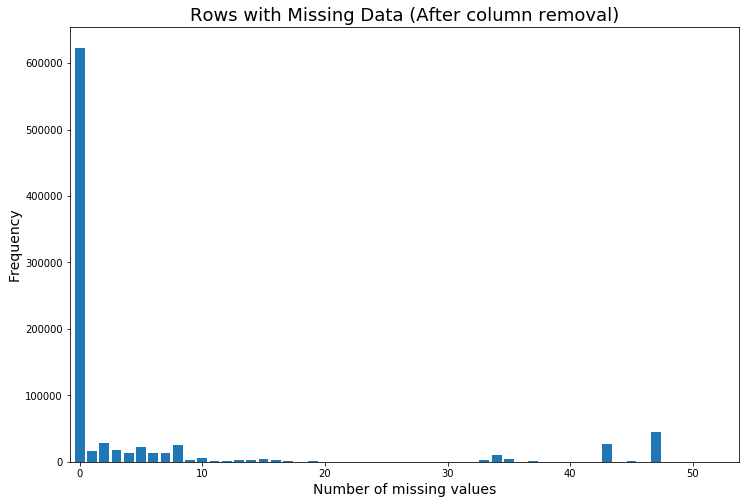

In [16]:
# How much data is missing in each row of the dataset?

dftemp = azdias.isnull().sum(axis=1).value_counts().sort_index()
plt.figure(figsize=(12,8))
plt.bar(x=dftemp.index, height=dftemp)
plt.xlabel('Number of missing values', fontsize=14)
plt.xlim([-0.8, 53.8])
plt.ylabel('Frequency', fontsize=14)
plt.title('Rows with Missing Data (After column removal)', fontsize=18);

To test whether the rows with any missing data are very different, I'll split the data into rows with the number of missing values less than or equal to that of the splitpoint constant, and those with more than the splitpoint constant. That way, I can adjust if needs be. I will try out 0, 10, and 20. 

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compdist(input_df, splitpoint, column_index):
    '''
    INPUTS: 
    input_df: Pandas DataFrame you want to draw comparative countplots for
    splitpoint: where you want to split the dataframe in terms of number of missing
                values per row.
    column_index: integer, a column index of the Dataframe you want to compare
    
    Produces side-by-side countplots for the column chosen 
    RETURN: -
    
    '''
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.
    df1 = input_df.loc[input_df.isnull().sum(axis=1)<=splitpoint]
    df2 = input_df.loc[input_df.isnull().sum(axis=1)>splitpoint]
    # Checking the split is OK. Will carry on if no AssertionError
    assert(df1.shape[0]+df2.shape[0]==input_df.shape[0])
    
    # Now plot comparison
    plt.figure(figsize=(11,5))
    str_title=input_df.columns[column_index]
     
    plt.subplot(1,2,1)
    sns.countplot(df1.iloc[:,column_index], color=sns.color_palette('pastel')[3])
    plt.title("Data <= {} Missing Values".format(splitpoint), fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xlabel("")
    
    plt.subplot(1,2,2)
    sns.countplot(df2.iloc[:,column_index], color=sns.color_palette('pastel')[5])
    plt.ylabel("")
    plt.title("Data > {} Missing Values".format(splitpoint), fontsize=14)
    plt.xlabel("")
    
    plt.suptitle('Comparing Subsets on {}'.format(str_title), fontsize=18, y=0.98);
    return

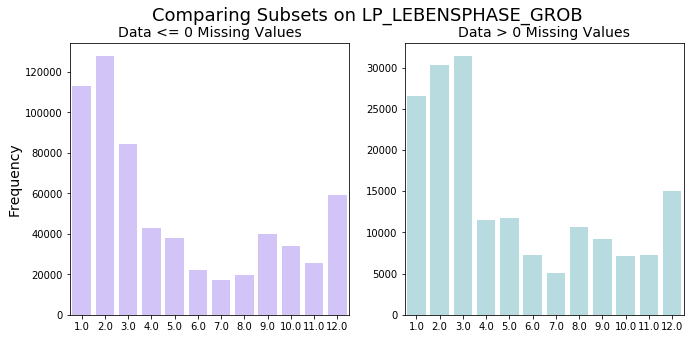

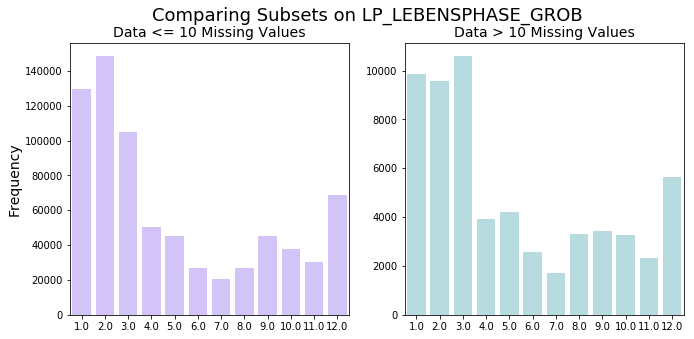

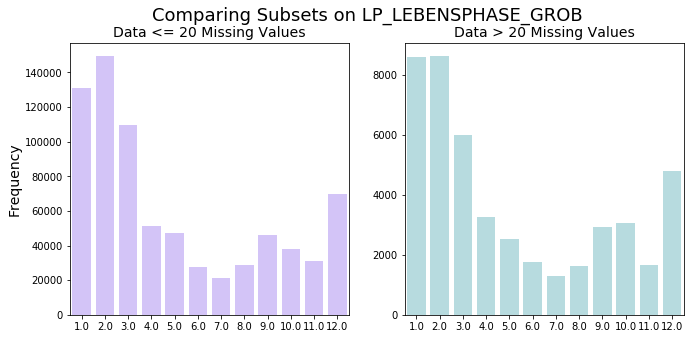

In [18]:
# Comparing lifestage (single low income to high income multi-person households):
compdist(azdias, 0, 14)
compdist(azdias, 10, 14)
compdist(azdias, 20, 14)

A subtle difference here is that there is a slight overrepresentation of people in lifestage 3 (single high-income earners) in the data-missing categories. The difference is not large, however, and it is smaller if you use a split-point at 20 rather than 0.

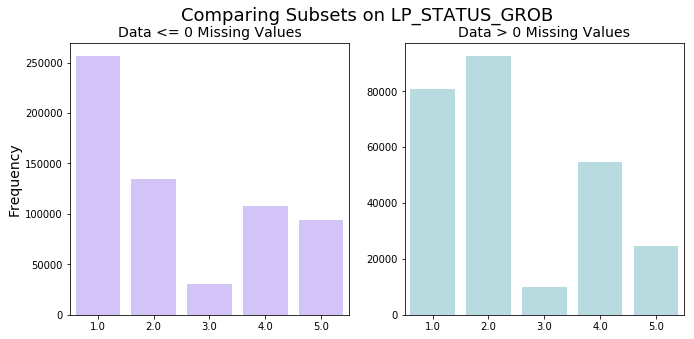

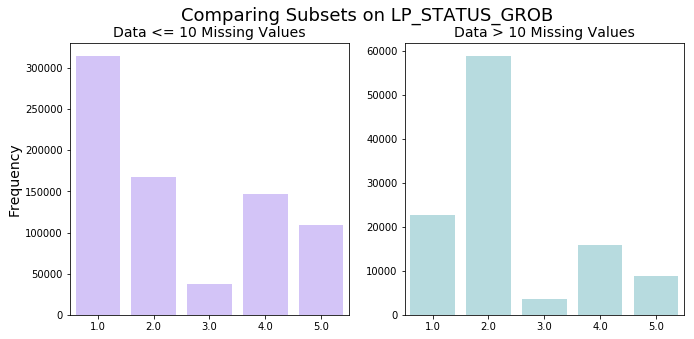

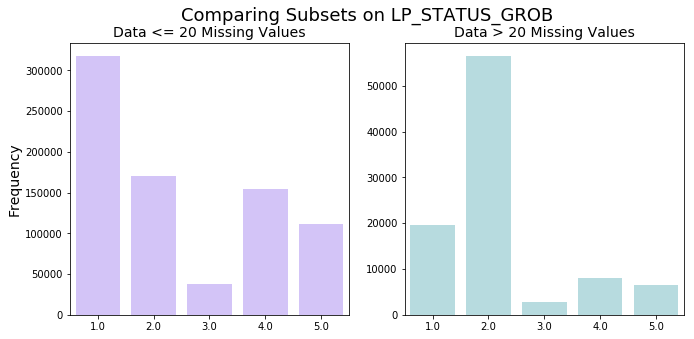

In [19]:
# Comparing social status (low-income to top-earners):
compdist(azdias, 0, 18)
compdist(azdias, 10, 18)
compdist(azdias, 20, 18)

There's more of a difference here in that average earners are overrepresented in the data-missing group. Higher-earners too are underrepresented when you move the splitpoint to 20. What seems to be happening is that the people for whom we have the patchiest data seem to be more likely to be higher-earning, but then people for whom we have a couple of bits of data missing seem to be more likely to average-earning. 

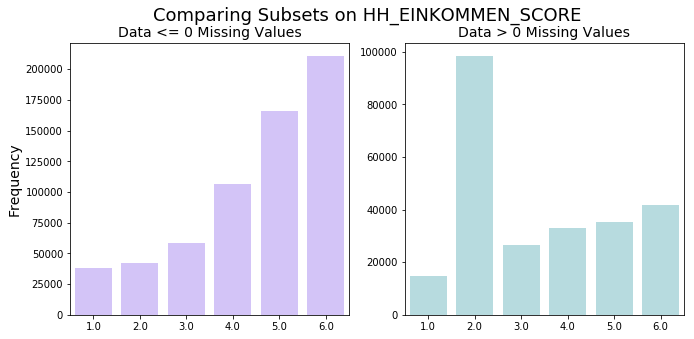

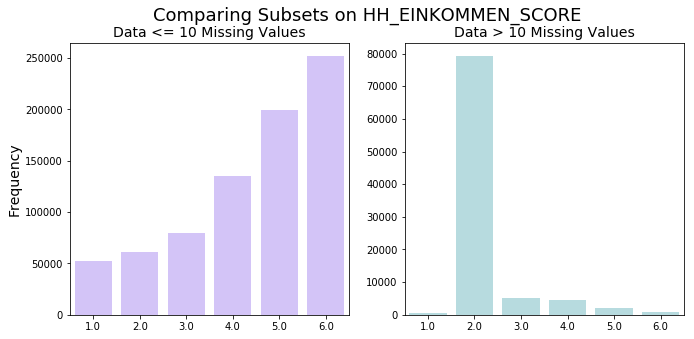

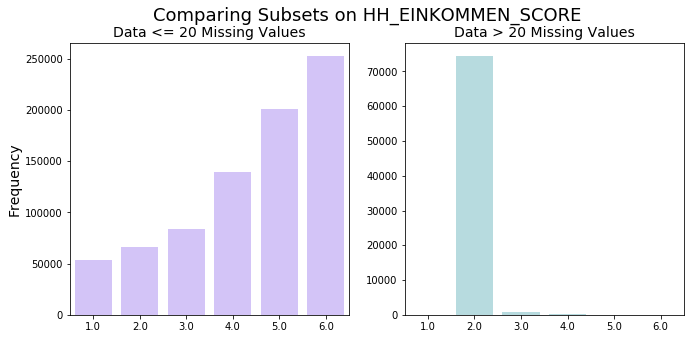

In [20]:
# Comparing estimated household net income (low to high):
compdist(azdias, 0, 42)
compdist(azdias, 10, 42)
compdist(azdias, 20, 42)

Here we have quite marked differences between the subsets. What is so striking here is the overwhelming domination of group 2 (households estimated to have very high income) in the observations with over 20 missing values. This is such a strong effect that, even if we move the splitpoint to 0, the two subsets are very different. What this suggests is that there will be no splitpoint we can pick that will be neutral - whatever we do, we are going to bias things in one direction or another. Unless we know the observations with more missing values are problematic *because* they lack key values (e.g. the estimated household income relies on information that's also missing), it is going to be difficult to justify excluding such rows from the analysis.

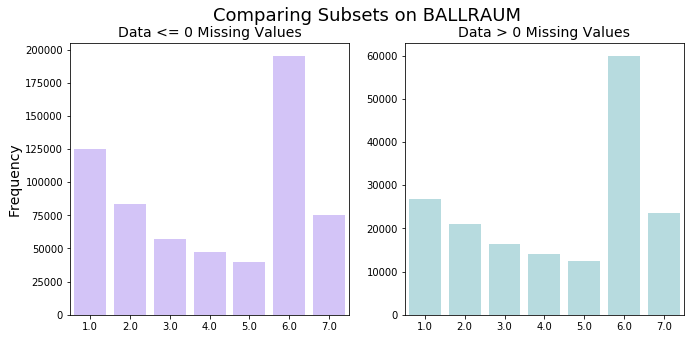

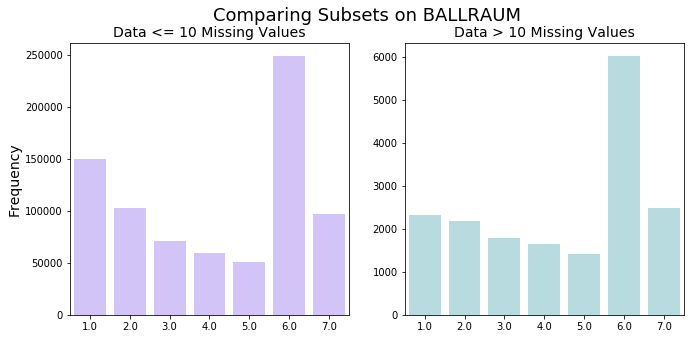

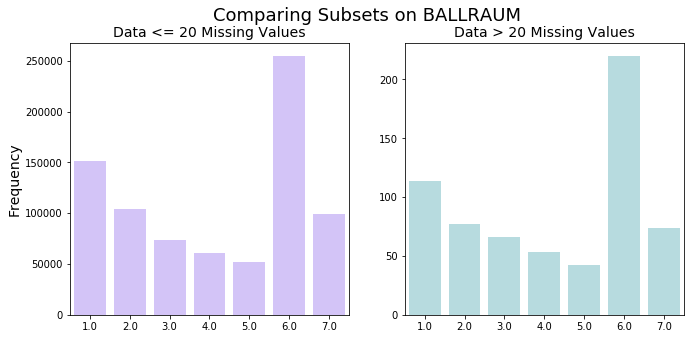

In [21]:
# Comparing distance to nearest urban centre
compdist(azdias, 0, 60)
compdist(azdias, 10, 60)
compdist(azdias, 20, 60)

There is little of concern here. It's actually fairly remarkable how consistent the proportions are, with the modal category being group 6 (50-100km to the nearest urban centre). It would appear that, at least on this metric, the observations with lots of missing values are very similar to the observations without missing values.

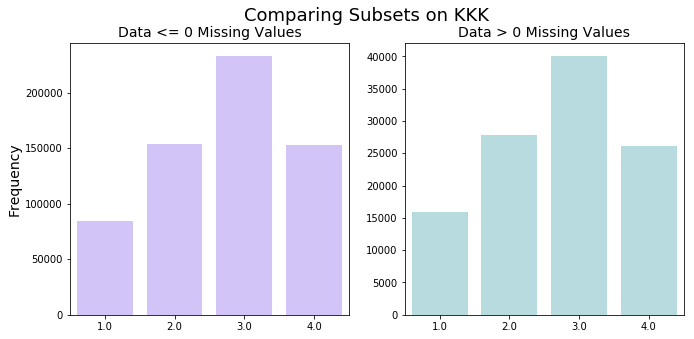

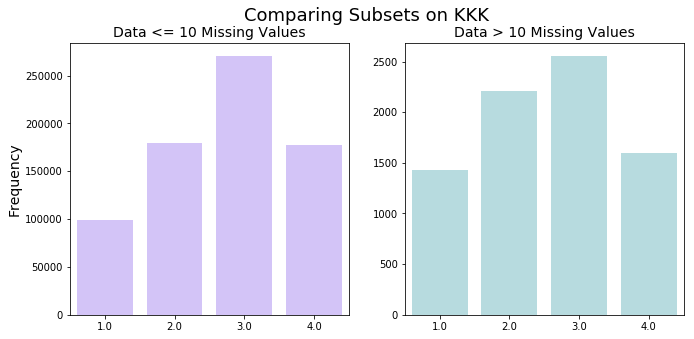

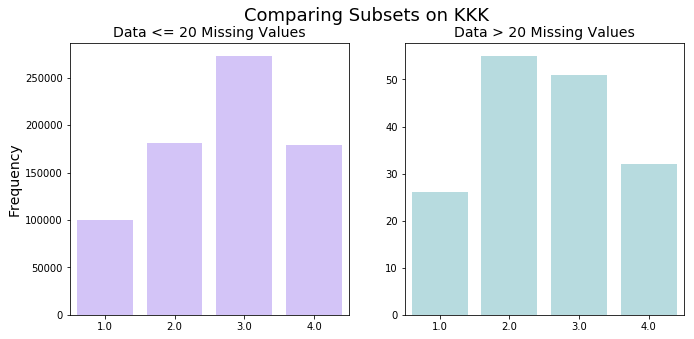

In [22]:
# Comparing purchasing power in the region
compdist(azdias, 0, 64)
compdist(azdias, 10, 64)
compdist(azdias, 20, 64)

Finally, we see little difference in the relative proportions of purchasing power parity per region, with only the 'Data >20 missing values' showing any difference. This is probably due to the very low numbers of observations here, so again we wouldn't say that the rows with missing data are very different on *this* particular metric.

I have concerns about treating the rows with missing data as sufficiently similar to the rows without missing data to justify their removal, but I will proceed according to the instruction that "...you should continue your analysis for now using just the subset of the data with few or no missing values." Since there is no particular reason for me to favour a splitpoint of 10 or 20, I may as well proceed with a dataset where I have no missing values at all. 

One saving grace here is that I will be doing the same thing for both the customer subset and the population subset. Thus, although there are concerns about the distortions introduced by dropping quite a few rows from the dataset, this shouldn't threaten the validity of any _comparative_ observations between the customer subset and the population. What may happen, however, is that I fail to detect particular clusters that would have been detectable on a different analysis. 

In [23]:
azdias = azdias.loc[azdias.isnull().sum(axis=1)==0,:]

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [25]:
# Get list of categorical variables
catlist = list(feat_info[feat_info.type=='categorical'].attribute)

# Get list of ordinal variables
ordlist = list(feat_info[feat_info.type=='ordinal'].attribute)

# Get list of ordinal variables
mixedlist = list(feat_info[feat_info.type=='mixed'].attribute)

In [26]:
feat_info[feat_info.type=='categorical']

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1, 0]"


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binlist=[]
nonbinlist=[]
for cat in catlist:
    if azdias[cat].nunique()==2:
        binlist.append(cat)
    else:
        nonbinlist.append(cat)
binlist

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

OST_WEST_KZ is the category being referred to here. I will rename it as WEST_KZ and map O to 0 and W to 1. The other binary categories are good to go.

In [28]:
# Renaming OST_WEST_KZ (in feat_list too!)
azdias.rename(columns= {'OST_WEST_KZ': 'WEST_KZ'}, inplace=True)
feat_info.loc[55][0]='WEST_KZ'

# Remapping values
azdias['WEST_KZ']=azdias['WEST_KZ'].map({'O':0, 'W':1})

# Checking
azdias['WEST_KZ'].value_counts()

1    490879
0    132330
Name: WEST_KZ, dtype: int64

In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias = pd.get_dummies(azdias, columns=['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB',
                                'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 
                                'GEBAEUDETYP', 'CAMEO_DEUG_2015'])

# Create list of columns to be dropped (note it includes the fine ones too)
droplist = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 
            'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015',
           'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']

# Drop columns from both dataframes
azdias = azdias.loc[:, azdias.columns.isin(droplist)==False]
feat_info = feat_info[feat_info['attribute'].isin(droplist)==False]

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
# Add new column JUGENDDEKADE for decade of youth and fill it with np.nans
azdias['JUGENDDEKADE'] = np.nan

# Now assign values based on PRAEGENDE_JUGENDJAHRE categories
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'JUGENDDEKADE']=40
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([3,4]),'JUGENDDEKADE']=50
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]),'JUGENDDEKADE']=60
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([8,9]),'JUGENDDEKADE']=70
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'JUGENDDEKADE']=80
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([14,15]),'JUGENDDEKADE']=90

# Check
azdias.JUGENDDEKADE.value_counts()

90.0    178212
70.0    143778
80.0    121578
60.0     95745
50.0     62474
40.0     21422
Name: JUGENDDEKADE, dtype: int64

In [31]:
# Add new column AVANTGARDEJUGEND for whether youth was avantgarde (1) or mainstream (0)
azdias['AVANTGARDEJUGEND'] = np.nan
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'AVANTGARDEJUGEND']=0
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'AVANTGARDEJUGEND']=1
                                                
# Check
azdias.AVANTGARDEJUGEND.value_counts()

0.0    476988
1.0    146221
Name: AVANTGARDEJUGEND, dtype: int64

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['CAMEO_INTL_REICHTUM'] = np.nan
azdias.loc[azdias['CAMEO_INTL_2015'].isin(['11','12','13','14','15']),'CAMEO_INTL_REICHTUM']=1
azdias.loc[azdias['CAMEO_INTL_2015'].isin(['21','22','23','24','25']),'CAMEO_INTL_REICHTUM']=2
azdias.loc[azdias['CAMEO_INTL_2015'].isin(['31','32','33','34','35']),'CAMEO_INTL_REICHTUM']=3
azdias.loc[azdias['CAMEO_INTL_2015'].isin(['41','42','43','44','45']),'CAMEO_INTL_REICHTUM']=4
azdias.loc[azdias['CAMEO_INTL_2015'].isin(['51','52','53','54','55']),'CAMEO_INTL_REICHTUM']=5

azdias['CAMEO_INTL_LEBENSPHASE'] = np.nan
azdias.loc[azdias['CAMEO_INTL_2015'].isin(['11','21','31','41','51']),'CAMEO_INTL_LEBENSPHASE']=1
azdias.loc[azdias['CAMEO_INTL_2015'].isin(['12','22','32','42','52']),'CAMEO_INTL_LEBENSPHASE']=2
azdias.loc[azdias['CAMEO_INTL_2015'].isin(['13','23','33','43','53']),'CAMEO_INTL_LEBENSPHASE']=3
azdias.loc[azdias['CAMEO_INTL_2015'].isin(['14','24','34','44','54']),'CAMEO_INTL_LEBENSPHASE']=4
azdias.loc[azdias['CAMEO_INTL_2015'].isin(['15','25','35','45','55']),'CAMEO_INTL_LEBENSPHASE']=5

# Check
azdias.CAMEO_INTL_LEBENSPHASE.value_counts(), azdias.CAMEO_INTL_REICHTUM.value_counts()

(1.0    198278
 4.0    187514
 5.0     93590
 3.0     88280
 2.0     55547
 Name: CAMEO_INTL_LEBENSPHASE, dtype: int64, 5.0    184469
 4.0    155270
 2.0    143545
 1.0     88560
 3.0     51365
 Name: CAMEO_INTL_REICHTUM, dtype: int64)

In [33]:
mixedlist

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [34]:
azdias.PLZ8_BAUMAX.value_counts()

1.0    391894
5.0     81656
2.0     59097
4.0     47397
3.0     43165
Name: PLZ8_BAUMAX, dtype: int64

In [35]:
azdias.WOHNLAGE.value_counts()

3.0    204534
7.0    132068
4.0    109059
2.0     79948
5.0     56113
1.0     36612
8.0      4871
0.0         4
Name: WOHNLAGE, dtype: int64

In [36]:
azdias.shape

(623209, 130)

#### Discussion 1.2.2: Engineer Mixed-Type Features

We have a doubling up again with the fine and coarse versions, this time with LP_LEBENSPHASE (life-stage), so I will again drop the fine-grained one. For the coarse one, I will convert it to a categorical variable since the ordinal values don't seem particularly worth preserving here.

For Wohnlage (Neighbourhood), we could separate this into an ordinal category for neighbourhood quality and a binary flag for rural neighbouhood. To do this, however, I will need to make the simplifying assumption that rural neighbourhoods are automatically 'very good neighbourhoods'.

Finally, for the PLZ8_BAUMAX variable, I'll split this into a binary flag for business district and an ordinal category for the size of family homes. Again, in order to preserve the ordinal category, I will make an assumption here that mainly business buildings is something like being in a region with 20+ family homes or something like that. 

I'll also have to clean up some of these variables I'm no longer using.

In [37]:
# One-hot encoding for LP_LEBENSPHASE_GROB
azdias = pd.get_dummies(azdias, columns=['LP_LEBENSPHASE_GROB'])

In [38]:
# Creating binary rural flag
azdias['WOHNLAGE_LANDLICH'] = np.nan
azdias.loc[azdias['WOHNLAGE'].isin([7,8]),'WOHNLAGE_LANDLICH']=1
azdias.loc[azdias['WOHNLAGE'].isin([0,1,2,3,4,5]),'WOHNLAGE_LANDLICH']=0

# Check
azdias.WOHNLAGE_LANDLICH.value_counts(),

(0.0    486270
 1.0    136939
 Name: WOHNLAGE_LANDLICH, dtype: int64,)

In [39]:
# Creating neighbourhood quality variable (rural gets 'very high')
azdias['WOHNLAGE_QUAL'] = np.nan
azdias.loc[azdias['WOHNLAGE']==0,'WOHNLAGE_QUAL']=0
azdias.loc[azdias['WOHNLAGE']==1,'WOHNLAGE_QUAL']=1
azdias.loc[azdias['WOHNLAGE']==2,'WOHNLAGE_QUAL']=2
azdias.loc[azdias['WOHNLAGE']==3,'WOHNLAGE_QUAL']=3
azdias.loc[azdias['WOHNLAGE']==4,'WOHNLAGE_QUAL']=4
azdias.loc[azdias['WOHNLAGE'].isin([5,7,8]),'WOHNLAGE_QUAL']=5

# Check
azdias.WOHNLAGE_QUAL.value_counts()

3.0    204534
5.0    193052
4.0    109059
2.0     79948
1.0     36612
0.0         4
Name: WOHNLAGE_QUAL, dtype: int64

In [40]:
# Creating PLZ8 business district flag
azdias['PLZ8_GESCHAFT'] = np.nan
azdias.loc[azdias['PLZ8_BAUMAX']==5,'PLZ8_GESCHAFT']=1
azdias.loc[azdias['PLZ8_BAUMAX'].isin([1,2,3,4]),'PLZ8_GESCHAFT']=0

# Check
azdias.PLZ8_GESCHAFT.value_counts()

0.0    541553
1.0     81656
Name: PLZ8_GESCHAFT, dtype: int64

In [41]:
# Creating PLZ8 residential building type ordinal category
azdias['PLZ8_HAUSSIZE'] = np.nan
azdias.loc[azdias['PLZ8_BAUMAX']==1,'PLZ8_HAUSSIZE']=1
azdias.loc[azdias['PLZ8_BAUMAX']==2,'PLZ8_HAUSSIZE']=2
azdias.loc[azdias['PLZ8_BAUMAX']==3,'PLZ8_HAUSSIZE']=3
azdias.loc[azdias['PLZ8_BAUMAX']==4,'PLZ8_HAUSSIZE']=4
azdias.loc[azdias['PLZ8_BAUMAX']==5,'PLZ8_HAUSSIZE']=5

# Check
azdias.PLZ8_HAUSSIZE.value_counts()

1.0    391894
5.0     81656
2.0     59097
4.0     47397
3.0     43165
Name: PLZ8_HAUSSIZE, dtype: int64

Out of 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',  'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', and 'PLZ8_BAUMAX', only LP_LEBENSPHASE_GROB has been deleted (which happened when it got one-hot encoded. So the rest will be added to a droplist and dropped.

In [42]:
droplist = ['LP_LEBENSPHASE_FEIN', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']

azdias = azdias.loc[:, azdias.columns.isin(droplist)==False]
feat_info=feat_info[feat_info['attribute'].isin(droplist)==False]

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [43]:
# Checking for nulls (shouldn't be any)
azdias.isnull().sum()

ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
GREEN_AVANTGARDE            0
HEALTH_TYP                  0
RETOURTYP_BK_S              0
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
SEMIO_RAT                   0
SEMIO_KRIT                  0
SEMIO_DOM                   0
SEMIO_KAEM                  0
SEMIO_PFLICHT               0
SEMIO_TRADV                 0
SOHO_KZ                     0
VERS_TYP                    0
ANZ_PERSONEN                0
ANZ_TITEL                   0
HH_EINKOMMEN_SCORE          0
W_KEIT_KIND_HH              0
WOHNDAUER_2008              0
ANZ_HAUSHALTE_AKTIV         0
ANZ_HH_TIT

In [44]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Columns: 140 entries, ALTERSKATEGORIE_GROB to PLZ8_HAUSSIZE
dtypes: float64(67), int64(1), uint8(72)
memory usage: 370.9 MB


In [45]:
azdias.sample(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_3.0,GEBAEUDETYP_5.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,JUGENDDEKADE,AVANTGARDEJUGEND,CAMEO_INTL_REICHTUM,CAMEO_INTL_LEBENSPHASE,LP_LEBENSPHASE_GROB_1.0,LP_LEBENSPHASE_GROB_2.0,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENSPHASE_GROB_7.0,LP_LEBENSPHASE_GROB_8.0,LP_LEBENSPHASE_GROB_9.0,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,WOHNLAGE_LANDLICH,WOHNLAGE_QUAL,PLZ8_GESCHAFT,PLZ8_HAUSSIZE
103545,1.0,1.0,3.0,3.0,2.0,5.0,4.0,4.0,0.0,3.0,1.0,7.0,7.0,7.0,5.0,7.0,2.0,2.0,7.0,5.0,1.0,1.0,2.0,6.0,5.0,0.0,1.0,2.0,0.0,1.0,1.0,9.0,1.0,0.0,3.0,1992.0,0,3.0,0.0,0.0,0.0,4.0,2.0,6.0,4.0,4.0,2.0,4.0,5.0,2.0,974.0,1.0,3.0,3.0,1.0,5.0,3.0,4.0,9.0,3.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,90.0,0.0,2.0,4.0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,3.0
354101,2.0,2.0,4.0,2.0,4.0,3.0,2.0,1.0,0.0,1.0,2.0,4.0,5.0,7.0,7.0,3.0,3.0,5.0,6.0,7.0,4.0,4.0,5.0,6.0,7.0,0.0,1.0,3.0,0.0,4.0,2.0,9.0,2.0,0.0,5.0,1992.0,1,2.0,1.0,0.0,0.0,4.0,6.0,2.0,6.0,3.0,3.0,5.0,5.0,6.0,494.0,4.0,2.0,0.0,0.0,3.0,3.0,2.0,1.0,1.0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,80.0,0.0,1.0,4.0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,5.0,0.0,1.0
668265,2.0,2.0,2.0,4.0,1.0,2.0,3.0,4.0,1.0,2.0,2.0,2.0,5.0,7.0,7.0,2.0,2.0,5.0,3.0,6.0,4.0,7.0,7.0,6.0,7.0,0.0,1.0,1.0,0.0,3.0,4.0,6.0,3.0,0.0,1.0,1992.0,1,2.0,3.0,0.0,0.0,3.0,1.0,6.0,1.0,2.0,2.0,3.0,5.0,6.0,454.0,1.0,4.0,3.0,2.0,5.0,3.0,4.0,8.0,5.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,80.0,1.0,4.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,3.0,1.0,5.0
14494,2.0,2.0,4.0,5.0,2.0,5.0,4.0,2.0,0.0,2.0,3.0,1.0,2.0,5.0,7.0,5.0,3.0,5.0,5.0,7.0,4.0,7.0,7.0,7.0,7.0,0.0,1.0,5.0,0.0,5.0,1.0,9.0,1.0,0.0,5.0,1992.0,1,3.0,2.0,0.0,0.0,3.0,6.0,4.0,7.0,4.0,4.0,4.0,5.0,5.0,708.0,4.0,2.0,0.0,0.0,4.0,5.0,4.0,6.0,3.0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,90.0,0.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,4.0,0.0,1.0
464194,2.0,1.0,5.0,2.0,3.0,2.0,3.0,1.0,0.0,2.0,3.0,7.0,7.0,6.0,7.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [46]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Prepare feat_info DF to use
    feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.strip('[]').str.split(',')

    # Loop through feat_info to create nulls in df
    for i in range(0,85):
        df.loc[df.iloc[:, i].isin(feat_info.iloc[i]['missing_or_unknown']),
            df.columns[i]] = np.nan

    # drop ['TITEL_KZ','AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df = df.loc[:, df.columns.isin(['TITEL_KZ','AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX',
    'GEBURTSJAHR', 'ALTER_HH'])==False]

    # drop rows with missing values
    df = df.loc[df.isnull().sum(axis=1)==0,:]

    # Renaming OST_WEST_KZ 
    df.rename(columns= {'OST_WEST_KZ': 'WEST_KZ'}, inplace=True)

    # Remapping values for 'WEST_KZ'
    df['WEST_KZ']=df['WEST_KZ'].map({'O':0, 'W':1})

    # Re-encode categorical variable(s) to be kept in the analysis.
    df = pd.get_dummies(df, columns=['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB',
                                    'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 
                                    'GEBAEUDETYP', 'CAMEO_DEUG_2015'])
    
    # Have to manually add GEBAEUDETYP_5.0 here because the customer data doesn't have any and it
    # messes up the shape of the dataframe otherwise
    
    df['GEBAEUDETYP_5.0']=0

    # Add new column JUGENDDEKADE for decade of youth and fill it with np.nans
    df['JUGENDDEKADE'] = np.nan

    # Now assign values based on PRAEGENDE_JUGENDJAHRE categories
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'JUGENDDEKADE']=40
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([3,4]),'JUGENDDEKADE']=50
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]),'JUGENDDEKADE']=60
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([8,9]),'JUGENDDEKADE']=70
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'JUGENDDEKADE']=80
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([14,15]),'JUGENDDEKADE']=90

    # Add new column AVANTGARDEJUGEND for whether youth was avantgarde (1) or mainstream (0)
    df['AVANTGARDEJUGEND'] = np.nan
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'AVANTGARDEJUGEND']=0
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'AVANTGARDEJUGEND']=1

    df['CAMEO_INTL_LEBENSPHASE'] = np.nan
    df.loc[df['CAMEO_INTL_2015'].isin(['11','12','13','14','15']),'CAMEO_INTL_LEBENSPHASE']=1
    df.loc[df['CAMEO_INTL_2015'].isin(['21','22','23','24','25']),'CAMEO_INTL_LEBENSPHASE']=2
    df.loc[df['CAMEO_INTL_2015'].isin(['31','32','33','34','35']),'CAMEO_INTL_LEBENSPHASE']=3
    df.loc[df['CAMEO_INTL_2015'].isin(['41','42','43','44','45']),'CAMEO_INTL_LEBENSPHASE']=4
    df.loc[df['CAMEO_INTL_2015'].isin(['51','52','53','54','55']),'CAMEO_INTL_LEBENSPHASE']=5

    df['CAMEO_INTL_REICHTUM'] = np.nan
    df.loc[df['CAMEO_INTL_2015'].isin(['11','21','31','41','51']),'CAMEO_INTL_REICHTUM']=1
    df.loc[df['CAMEO_INTL_2015'].isin(['12','22','32','42','52']),'CAMEO_INTL_REICHTUM']=2
    df.loc[df['CAMEO_INTL_2015'].isin(['13','23','33','43','53']),'CAMEO_INTL_REICHTUM']=3
    df.loc[df['CAMEO_INTL_2015'].isin(['14','24','34','44','54']),'CAMEO_INTL_REICHTUM']=4
    df.loc[df['CAMEO_INTL_2015'].isin(['15','25','35','45','55']),'CAMEO_INTL_REICHTUM']=5

    # One-hot encoding for LP_LEBENSPHASE_GROB
    df = pd.get_dummies(df, columns=['LP_LEBENSPHASE_GROB'])

    # Creating binary rural flag
    df['WOHNLAGE_LANDLICH'] = np.nan
    df.loc[df['WOHNLAGE'].isin([7,8]),'WOHNLAGE_LANDLICH']=1
    df.loc[df['WOHNLAGE'].isin([0,1,2,3,4,5]),'WOHNLAGE_LANDLICH']=0

    # Creating neighbourhood quality variable (rural gets 'very high')
    df['WOHNLAGE_QUAL'] = np.nan
    df.loc[df['WOHNLAGE']==0,'WOHNLAGE_QUAL']=0
    df.loc[df['WOHNLAGE']==1,'WOHNLAGE_QUAL']=1
    df.loc[df['WOHNLAGE']==2,'WOHNLAGE_QUAL']=2
    df.loc[df['WOHNLAGE']==3,'WOHNLAGE_QUAL']=3
    df.loc[df['WOHNLAGE']==4,'WOHNLAGE_QUAL']=4
    df.loc[df['WOHNLAGE'].isin([5,7,8]),'WOHNLAGE_QUAL']=5

    # Creating PLZ8 business district flag
    df['PLZ8_GESCHAFT'] = np.nan
    df.loc[df['PLZ8_BAUMAX']==5,'PLZ8_GESCHAFT']=1
    df.loc[df['PLZ8_BAUMAX'].isin([1,2,3,4]),'PLZ8_GESCHAFT']=0

    # Creating PLZ8 residential building type ordinal category
    df['PLZ8_HAUSSIZE'] = np.nan
    df.loc[df['PLZ8_BAUMAX']==1,'PLZ8_HAUSSIZE']=1
    df.loc[df['PLZ8_BAUMAX']==2,'PLZ8_HAUSSIZE']=2
    df.loc[df['PLZ8_BAUMAX']==3,'PLZ8_HAUSSIZE']=3
    df.loc[df['PLZ8_BAUMAX']==4,'PLZ8_HAUSSIZE']=4
    df.loc[df['PLZ8_BAUMAX']==5,'PLZ8_HAUSSIZE']=5

    # Create list of columns to be dropped
    droplist = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 
                'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015',
               'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015', 'LP_LEBENSPHASE_FEIN', 
               'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']

    # Drop columns 
    df = df.loc[:, df.columns.isin(droplist)==False]
    
    return df

In [47]:
# Checking my clean_data function is equivalent

temp = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')
temp = clean_data(temp)
temp.shape, azdias.shape, azdias.columns, temp.columns

((623209, 140),
 (623209, 140),
 Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
        'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
        'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
        'HEALTH_TYP',
        ...
        'LP_LEBENSPHASE_GROB_7.0', 'LP_LEBENSPHASE_GROB_8.0',
        'LP_LEBENSPHASE_GROB_9.0', 'LP_LEBENSPHASE_GROB_10.0',
        'LP_LEBENSPHASE_GROB_11.0', 'LP_LEBENSPHASE_GROB_12.0',
        'WOHNLAGE_LANDLICH', 'WOHNLAGE_QUAL', 'PLZ8_GESCHAFT', 'PLZ8_HAUSSIZE'],
       dtype='object', length=140),
 Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
        'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
        'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
        'HEALTH_TYP',
        ...
        'LP_LEBENSPHASE_GROB_7.0', 'LP_LEBENSPHASE_GROB_8.0',
        'LP_LEBENSPHASE_GROB_9.0', 'LP_LEBENSPHASE_GROB_10.0',
        'LP_LEBENSPHASE_GROB_11.0', 'LP_LEBENSPHASE_GROB_12.0',
 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_azdias = scaler.fit_transform(azdias)

### Discussion 2.1: Apply Feature Scaling

Things were fairly straightforward here since I'd already removed missing values from the dataset, so it was literally just a case of creating the StandardScaler object and using fit_transform on the dataset azdias to create the numpy array scaled_azdias. This is now ready to have PCA performed on it.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
## Apply PCA to the data.

def applyPCA(n_dimensions=None, data=scaled_azdias):
    '''
    INPUT:
        n_dimensions - int - tells function how many dimensions to keep in the PCA
        data - the data you want to transform
    
    RETURNS:
        pca_object - the matrix being applied to the data
        dimred_data - the dimension_reduced data (i.e. after the matrix is applied)
    '''
       
    # Creating PCA object
    pca_object = PCA(n_components=n_dimensions)
    
    # Fitting scaled_azdias to the PCA object
    dimred_data = pca_object.fit_transform(data)
    
    return (pca_object, dimred_data)

In [50]:
pca_object, dimred_data = applyPCA()

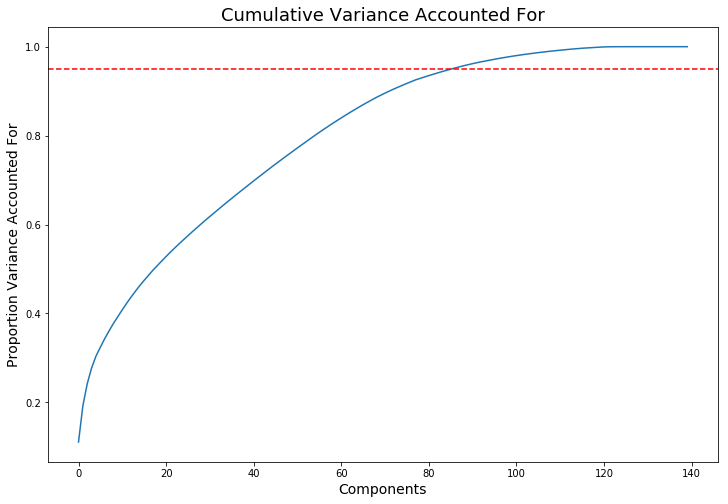

In [51]:
# Investigate the variance accounted for by each principal component.
VR = pca_object.explained_variance_ratio_
cumulative_VR = np.cumsum(VR)

plt.figure(figsize=(12,8))
plt.plot(cumulative_VR)
plt.xlabel('Components', fontsize=14)
plt.ylabel('Proportion Variance Accounted For', fontsize=14)
plt.title('Cumulative Variance Accounted For', fontsize=18)
plt.axhline(0.95, color='red', linestyle='--');

In [52]:
# Threshold where cumulative variance accounted for goes over 1

sum(cumulative_VR<0.95)+1

87

In [53]:
# Threshold where the additional variance accounted for is less than the average amount.

sum(VR>1/140)

51

In the above graph, we can see how the proportion of variance accounted for increases as the number of components increases. A dashed, red, horizontal line is shown at 95%, which is often used as a rule of thumb figure to use in dimensionality reduction when it comes to large numbers of dimensions like this.

An alternative could be to use the elbow or the criterion that the additional variance accounted for needs to be greater than the average. There isn't an obvious elbow, however, and using 51 components only would leave quite a lot of variance behind. From the other direction, you could argue that a 99% criterion (109 components) is a preferable option, but here we're only eliminating 31 components which isn't a great deal. Thus, I elect to use the 95% criterion, which seems to me a relatively decent compromise. 

In [54]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_object, dimred_data = applyPCA(0.95)

In [55]:
# Just checking this has created 87 components as anticipated.

pca_object.explained_variance_ratio_.shape

(87,)

### Discussion 2.2: Perform Dimensionality Reduction

As explained, I've reduced the data from 140 components to 87, resulting in a loss of 5% of the variance. This seemed to me to be a good trade-off point between preserving the information in the data whilst shedding some of the curse of dimensionality.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [56]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights(full_dataset, pca_object, dimension):
    
    components = pd.DataFrame(np.round(pca_object.components_, 3), columns = full_dataset.keys())
    s1 = components.iloc[dimension]
    s2 = s1[np.abs(s1)>0.15].sort_values(ascending=False)
    print(s2)

    return

map_weights(azdias, pca_object, 0)

LP_STATUS_GROB_1.0     0.187
PLZ8_ANTG3             0.179
PLZ8_ANTG4             0.175
PLZ8_HAUSSIZE          0.174
HH_EINKOMMEN_SCORE     0.173
CAMEO_INTL_REICHTUM    0.172
ORTSGR_KLS9            0.154
EWDICHTE               0.151
KBA05_GBZ             -0.177
PLZ8_ANTG1            -0.181
KBA05_ANTG1           -0.187
FINANZ_MINIMALIST     -0.196
MOBI_REGIO            -0.200
Name: 0, dtype: float64


In [57]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(azdias, pca_object, 1)

ALTERSKATEGORIE_GROB       0.220
FINANZ_VORSORGER           0.203
ZABEOTYP_3.0               0.197
SEMIO_ERL                  0.180
LP_LEBENSPHASE_GROB_2.0    0.157
RETOURTYP_BK_S             0.153
SEMIO_LUST                 0.151
SEMIO_RAT                 -0.156
ONLINE_AFFINITAET         -0.160
SEMIO_KULT                -0.164
FINANZ_ANLEGER            -0.187
SEMIO_TRADV               -0.198
SEMIO_PFLICHT             -0.201
FINANZ_UNAUFFAELLIGER     -0.204
FINANZ_SPARER             -0.207
SEMIO_REL                 -0.211
JUGENDDEKADE              -0.224
Name: 1, dtype: float64


In [58]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(azdias, pca_object, 2)

SEMIO_VERT        0.324
SEMIO_FAM         0.258
SEMIO_SOZ         0.257
SEMIO_KULT        0.244
FINANZ_ANLEGER   -0.156
SEMIO_RAT        -0.164
SEMIO_ERL        -0.198
SEMIO_KRIT       -0.263
SEMIO_DOM        -0.286
SEMIO_KAEM       -0.318
ANREDE_KZ        -0.346
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components


First Component:

* LP_STATUS_GROB_1.0 indicates a low-income earner. The first component increases if the person is a low-income earner.
* PLZ8_ANTG3 (6-10 family houses) and PLZ8_ANTG4 (10+ family houses) are both such that, the higher the number, the greater the number in the PLZ8 region the person is in, and the more the first component increases. Meanwhile, PLZ8_ANTG1 (1-2 family houses) is negatively linked to the first component. So presumably what's happening here is that the number of large family houses in the area is associated with low income areas. 
* PLZ8_HAUSSIZE is a variable I created, and it concerns the preponderance of large family houses in the area. It too increases with the first component. 
* HH_EINKOMMEN_SCORE increases as income goes down, so the first component is again pointing to low income, i.e. the less well-off.
* CAMEO_INTL_REICHTUM is a variable I created, with higher values indicating less wealthy households. So again, the first component is pointing to the less well-off.
* ORTSGR_KLS9 is size of community, increasing as the community becomes more dense. EWDICHTE too is a measure of density, increasing as the number of households increases per square kilometre. 
* KBA05_GBZ goes up as the number of buildings in the 'microcell' goes up, and our first component is negatively weighted with that. Poorer neighbourhoods tend to have lower numbers of buildings, each housing many more families, so this makes sense. Similarly, KBA05_ANTG1 goes up with the number of 1-2 family homes, and our first compenent is also negatively weighted with that. 
* FINANZ_MINIMALIST is a psychological measurement of a person's lack of interest in financial matters, with higher values indicating lower interest. Interestingly, our first component is weighted such that it increases with people having more financial interest - this corresponds to the basic idea that the least well-off you are, the more you are preoccupied by financial matters.
* MOBI_REGIO is about how mobile people are in the region of the person questioned, with higher values indicating less mobility. Negative weighting here means that our first component increases as people are more mobile in the region.

Overall, then, the first component is broadly concerned with identifying the less well-off, who live in mobile, dense areas. 

For the Second Component, the following are positively-weighted:

* ALTERSKATEGORIE_GROB - the higher the number, the higher the estimated age
* FINANZ_VORSORGER - the higher the number, the less financially-prepared
* ZABEOTYP_3.0 - indicates 'fair supplied' Energy consumption
* SEMIO_ERL - the higher the number, the more event-oriented
* LP_LEBENSPHASE_GROB_2.0 - indicates single low-income and average earners of higher age
* RETOURTYP_BK_S - the higher the number, the less someone returns goods to a shop
* SEMIO_LUST - the higher the number, the more sensual-minded

Whereas the following are negatively-weighted:

* SEMIO_RAT - the higher the number, the less rational 
* ONLINE_AFFINITAET - the higher the number, the more comfortable online
* SEMIO_KULT - the higher the number, the less culturally-minded
* FINANZ_ANLEGER - the higher the number, the less of an investor mindset
* SEMIO_TRADV - the higher the number, the less traditionally-minded
* SEMIO_PFLICHT - the higher the number, the less dutiful
* FINANZ_UNAUFFAELLIGER - the higher the number, the less of an inconspicious financial mindset
* FINANZ_SPARER - the higher the number, the less of a money-saver
* SEMIO_REL - the higher the number, the less religiously-minded
* JUGENDDEKADE - the higher the number, the older the decade of your youth

Overall, this seems to be picking out youth markers, especially stereotypically Millennial characteristics such as event-driven, sensation-seeking, pecuniary irresponsibility, etc.

For the Third Component, the following are positively-weighted:

* SEMIO_VERT - the higher the number, the less the person is a dreamer
* SEMIO_FAM - the higher the number, the less the person is family-oriented
* SEMIO_SOZ - the higher the number, the less the person is socially-minded
* SEMIO_KULT - the higher the number, the less the person is culturally-minded

Whereas the following are negatively-weighted:

* FINANZ_ANLEGER - the higher the number, the less of an investor mindset
* SEMIO_RAT - the higher the number, the less rational 
* SEMIO_ERL - the higher the number, the less event-oriented
* SEMIO_KRIT - the higher the number, the less critically-minded
* SEMIO_DOM - the higher the number, the less dominant-minded
* SEMIO_KAEM - the higher the number, the less combative in attitude
* ANREDE_KZ - indicates female

Overall, then, we seem to have something of a gender component here, with stereotypically feminine psychologically traits (family-orientation, social-mindedness, less disagreeable, etc) resulting in a lower score on the third principle component. This is of course enforced by the relatively high weight placed on gender itself. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [59]:
# Defining function so we can do this over a number of different cluster counts...
def get_kmeans_average_inertia(data, n_centres):
    '''
    INPUT:
        data - the dataset you want to fit kmeans to
        n_centres - the number of centres you want
    OUTPUT:
        average_inertia - the average inertia (i.e. squared distance from datum to centroid) 
        for the fitted kmeans model
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters = n_centres)

    # run k-means clustering on the data and...
    model = kmeans.fit(data)

    # compute the average within-cluster (squared) distances.
    average_inertia = model.inertia_ / data.shape[0]

    return average_inertia 

In [60]:
## Investigate the change in within-cluster (squared) distance across number of clusters.
## HINT: Use matplotlib's plot function to visualize this relationship.

## Below is the code I used to generate the list of average squared distances for each number of 
## clusters. I've commented it out because it takes two hours to run each time and I've already 
## run it twice. The results are stored below under heights_store and heights_store2.

# import time
#
# x = []
# heights = []
#
# for _ in range(2, 31):
#    
#     start = time.time()
#     x.append(_)
#     heights.append(get_kmeans_average_inertia(dimred_data, _))
#     print("Finished number {}. Time taken: {:.1f} minutes.".format(_, (time.time() - start)/60))

x_store = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
           17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

heights_store = [121.62454514334314, 115.26442179491725, 111.61380619010139, 109.25308483025788,
107.27397882494401, 105.48923490150007, 104.05940571688473, 102.6068940609111, 101.45484896717358, 
100.46381414336828, 99.146418083619039, 98.023313884082341, 96.930597128247541, 96.305347787932547, 
95.125971134621537, 94.127840370733011, 93.663778310896632, 92.350626409967163, 92.271280233508961, 
91.586901473647373, 90.667858136874756, 90.419835786849347, 89.829405952335392, 88.750952088608187, 
88.878483568494516, 88.707919909782106, 87.787394488356995, 87.366054992871398, 87.290272904015225]

heights_store2 = [121.62454439484887, 115.26441958192932, 111.61377706392561, 109.25308520202795, 
                  107.27398374760945, 105.48923536471186, 104.11331966826916, 102.60687750937454, 
                  101.43313683622939, 100.4209372305133, 99.004416652348397, 97.982056675861998, 
                  97.109685542093374, 95.850145538106773, 95.261577352712294, 94.264006614700236, 
                  93.479831406928852, 92.916755016589633, 91.458937476073274, 91.355407483439762,
                  91.007846090131594, 90.102003145300102, 89.81427640458557, 89.306330969375992, 
                  89.003073468989101, 88.507556345197216, 87.775760769615047, 87.195451744554447, 
                  87.677463208494004]

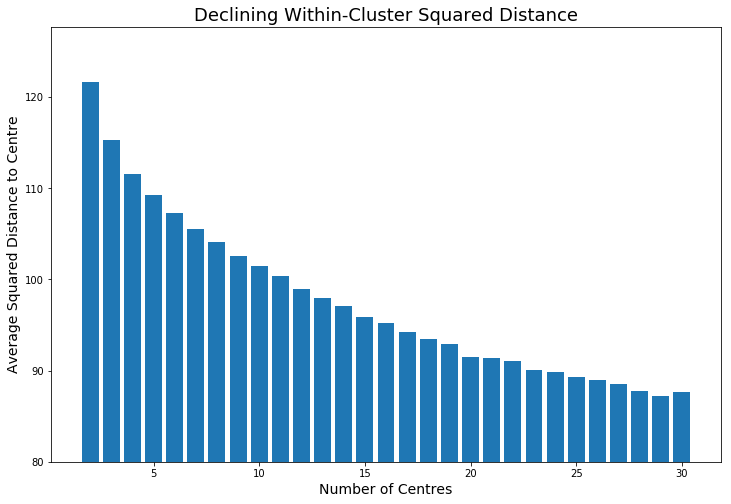

In [61]:
plt.figure(figsize=(12,8))
plt.bar(x_store, heights_store2)
plt.xlabel('Number of Centres', fontsize=14)
plt.ylabel('Average Squared Distance to Centre', fontsize=14)
plt.ylim(80)
plt.title('Declining Within-Cluster Squared Distance', fontsize=18);

In [62]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_model = KMeans(n_clusters = 23).fit(dimred_data)
pop_labels = kmeans_model.predict(dimred_data)

### Discussion 3.1: Apply Clustering to General Population

There were a few sensible points to stop in terms of the number of clusters to employ, i.e. where an extra centroid doesn't give us very much reduction in average distance. The first set of values I got suggested that 19, 22 or 25 were particularly good points to use, and the second set suggested 20, 23, and 29 were good points to use. Thus, any number of clusters in this sort of region would probably work. In the end, I opted for 23 clusters. This gives us plenty of fine-grained clusters with which to make comparisons between the customer and population subsets, without becoming so convoluted as to become unwieldy.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [63]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.shape

(191652, 85)

In [64]:
clean_customers = clean_data(customers)
clean_customers.shape

(115643, 140)

In [65]:
# Had issues here with GEBAEUDETYP_5.0 not appearing in the customer dataset. This cell was for 
# diagnosing the problem. 

tlist = list(temp.columns) 
clist = list(clean_customers.columns)

set(tlist)-set(clist)

set()

In [66]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean, wrangle, and reengineer customer data
clean_customers = clean_data(customers)

# Apply scaling based on population data
scaled_customers = scaler.transform(clean_customers)

# Apply PCA model based on population data
dimred_customers = pca_object.transform(scaled_customers)

# Apply KMeans model to obtain cluster evaluations
cust_labels = kmeans_model.predict(dimred_customers)

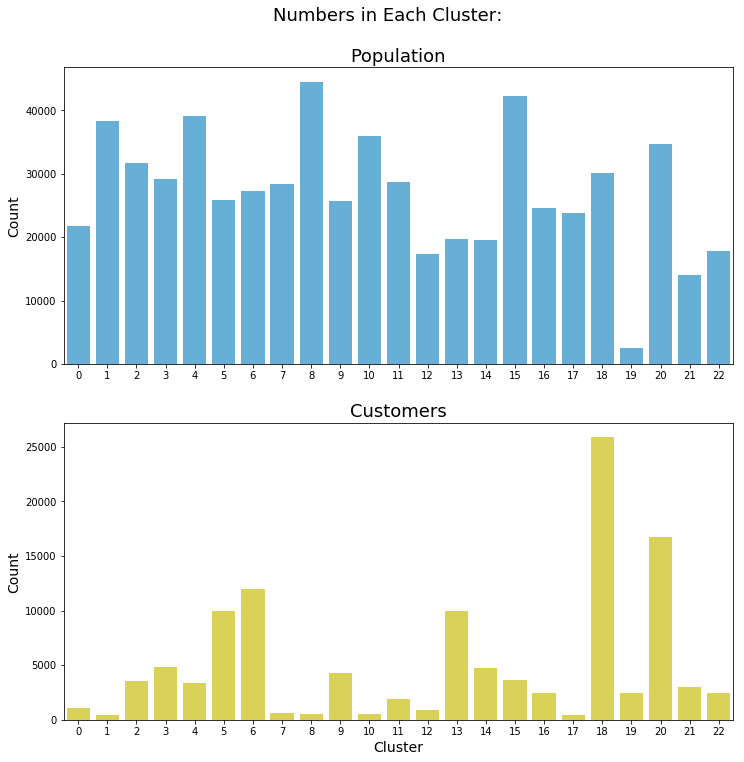

In [67]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.countplot(pop_labels, color=sns.color_palette('colorblind')[5])
plt.ylabel('Count', fontsize=14)
plt.title('Population', fontsize=18)

plt.subplot(2,1,2)
sns.countplot(cust_labels, color=sns.color_palette('colorblind')[4])
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Customers', fontsize=18)
plt.suptitle('Numbers in Each Cluster:', fontsize=18, y=0.95);



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

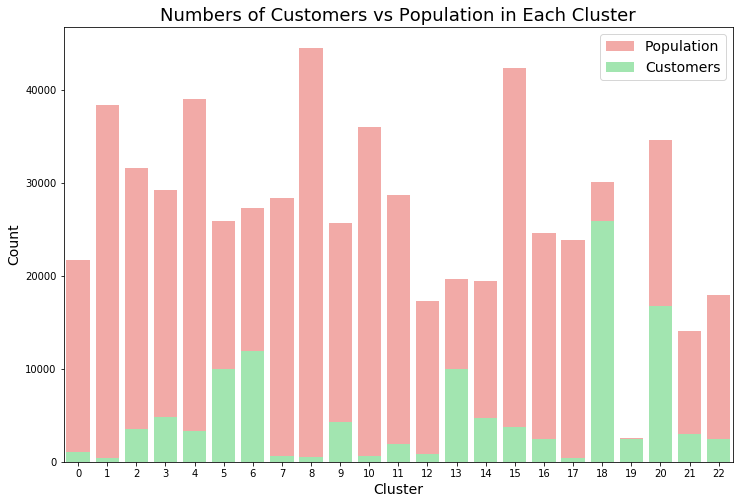

In [68]:
# First attempt at trying to get a sense of which clusters are under- and over-represented in the
# customer subset

plt.figure(figsize=(12,8))

sns.countplot(pop_labels, color=sns.color_palette('pastel')[2], label='Population')
plt.ylabel('Count', fontsize=14)
plt.title('Population', fontsize=18)

sns.countplot(cust_labels, color=sns.color_palette('pastel')[1], label='Customers')
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Numbers of Customers vs Population in Each Cluster', fontsize=18)
plt.legend(fontsize=14);


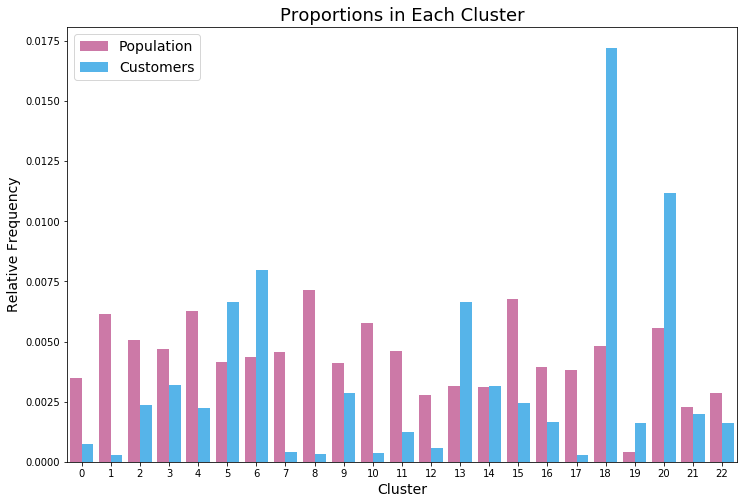

In [69]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

pop_props=[]
cust_props=[]
ratio=[]
for _ in range(23):
    pop_prop = (pop_labels==_).sum() / pop_labels.sum()
    cust_prop = (cust_labels==_).sum() / cust_labels.sum()
    pop_props.append(pop_prop)
    cust_props.append(cust_prop)
    ratio.append(cust_prop / pop_prop)
    
plt.figure(figsize=(12,8))
plt.xticks(np.arange(0,23,1))
plt.bar(x=(np.arange(0,23,1)-0.2), height = pop_props, width=0.4,
        color=sns.color_palette('colorblind')[3], label='Population')
plt.bar(x=(np.arange(0,23,1)+0.2), height = cust_props, width=0.4, 
        color=sns.color_palette('colorblind')[5], label='Customers')
plt.xlim([-0.5,22.5])
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Relative Frequency', fontsize=14)
plt.title('Proportions in Each Cluster', fontsize=18)
plt.legend(fontsize=14);

In [70]:
# Showing the clusters that are, from most to least, proportionally 
# overrepresented in customers compared to pop
ratio=pd.Series(ratio)
ratio.sort_values(ascending=False)

19    3.970775
18    3.569621
13    2.111602
20    2.012838
6     1.821557
5     1.602789
14    1.005087
21    0.884868
9     0.698172
3     0.685469
22    0.565456
2     0.462140
16    0.415476
15    0.362280
4     0.356731
11    0.271150
0     0.206985
12    0.205583
7     0.091263
17    0.073372
10    0.065939
8     0.046662
1     0.045687
dtype: float64

In [71]:
# What kinds of people are part of a cluster that is over-/under-represented in the
# customer data compared to the general population?

def get_centroid_info(cluster):
    '''
    INPUT int - which cluster you want the information on
    RETURN pandas series with the values for the centroid of that cluster on the 140-value df
    '''
    # Get matrix of centres for designated cluster 
    centre_a = kmeans_model.cluster_centers_[cluster]
    
    # inverse transform using pca_object
    centre_b = pca_object.inverse_transform(centre_a)
    
    # inverse transform using scaling
    centre_c = scaler.inverse_transform(centre_b)

    # Change to a pandas series with the azdias columns as index. Round to 1dp.
    centre = pd.Series(centre_c, index = azdias.columns).round(1)
    return centre


# Print a dataframe with each cluster centroid as a row so you can compare the demographic info
# for each cluster.
df = pd.DataFrame([get_centroid_info(0)])
for _ in range(1, 23):

    df2 = pd.DataFrame([get_centroid_info(_)])
    df = pd.concat([df, df2], ignore_index=True)

# DF slice showing two over-represented clusters, two perfectly-represented clusters, then
# two under-represented clusters    
df.iloc[[0,10,16,1,11,2]]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_3.0,GEBAEUDETYP_5.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,JUGENDDEKADE,AVANTGARDEJUGEND,CAMEO_INTL_REICHTUM,CAMEO_INTL_LEBENSPHASE,LP_LEBENSPHASE_GROB_1.0,LP_LEBENSPHASE_GROB_2.0,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENSPHASE_GROB_7.0,LP_LEBENSPHASE_GROB_8.0,LP_LEBENSPHASE_GROB_9.0,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,WOHNLAGE_LANDLICH,WOHNLAGE_QUAL,PLZ8_GESCHAFT,PLZ8_HAUSSIZE
0,2.2,1.7,2.3,3.6,2.8,3.8,3.2,3.2,0.2,2.3,2.7,3.8,3.9,4.5,4.2,3.5,3.5,4.4,4.2,4.9,4.9,5.2,4.9,5.1,4.6,0.0,1.5,1.5,0.0,4.8,1.7,7.7,7.5,0.0,3.1,1992.6,0.8,1.5,1.3,0.7,0.2,3.2,4.2,3.9,4.6,3.8,2.8,3.0,4.2,4.5,625.8,2.3,2.8,1.6,0.7,3.6,3.4,3.2,5.2,3.1,0.1,0.1,0.2,0.3,0.2,0.2,0.5,0.0,0.0,0.1,0.0,0.3,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.3,0.1,0.1,0.2,0.0,0.0,1.0,-0.0,-0.0,0.5,0.2,0.0,0.1,0.1,0.8,0.1,0.1,0.2,0.3,0.4,0.2,0.1,0.0,0.1,0.6,0.1,0.0,0.6,0.2,0.0,0.2,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.2,0.1,83.6,0.2,3.3,2.8,-0.0,0.0,0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.2,3.6,0.1,1.9
10,1.7,2.0,1.9,4.2,2.1,4.5,4.0,3.3,0.2,2.2,2.4,2.6,3.5,4.9,4.8,2.4,3.1,4.3,3.9,6.1,5.5,6.0,5.5,5.9,5.8,0.0,1.4,1.6,0.0,4.5,4.1,7.4,3.8,0.0,3.7,1992.7,0.9,2.2,1.4,0.3,0.0,3.9,4.9,2.9,5.5,4.0,2.6,3.8,3.3,4.2,702.1,2.9,2.4,1.0,0.2,3.5,3.9,2.7,3.9,2.5,0.1,0.0,0.3,0.3,0.1,0.3,0.6,0.0,0.0,0.2,0.0,0.1,0.1,0.1,0.1,0.0,0.1,0.0,0.0,0.1,0.1,0.1,0.1,0.2,0.6,0.1,0.0,0.0,0.3,0.3,0.6,0.0,0.1,0.0,0.8,0.1,0.1,0.1,0.3,0.4,0.2,0.1,0.0,0.0,0.5,0.3,0.1,0.7,0.1,-0.0,0.2,0.1,0.1,0.2,0.2,0.1,0.1,0.1,0.1,0.0,87.5,0.2,2.5,3.3,0.5,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.4,3.8,0.0,1.1
16,2.2,1.5,3.9,3.5,2.0,3.6,3.7,1.5,0.5,2.2,2.8,4.7,4.6,4.9,4.4,4.7,3.8,3.8,5.0,4.5,3.8,4.5,3.9,5.2,4.6,0.0,1.5,3.6,0.0,3.1,2.4,8.7,1.4,0.0,3.7,1992.8,0.9,2.7,1.1,0.1,0.0,4.2,4.8,3.1,5.3,4.0,2.6,4.2,4.4,4.1,667.9,2.9,2.4,1.0,0.3,3.5,3.8,2.8,4.2,2.6,0.1,0.0,0.2,0.4,0.2,0.2,0.1,0.0,0.4,0.2,0.0,0.3,0.1,0.1,0.1,0.0,0.1,0.0,0.1,0.1,0.1,0.2,0.1,0.1,0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,0.2,0.4,0.4,0.9,0.1,0.0,0.3,0.3,0.2,0.2,0.4,0.2,0.0,0.3,0.0,0.0,0.7,0.2,-0.0,0.1,0.1,0.2,0.2,0.2,0.1,0.1,0.1,0.0,0.0,87.2,0.5,2.3,3.4,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0,0.4,3.6,0.0,1.1
1,1.9,1.0,1.8,4.5,1.9,3.5,3.9,3.6,0.1,2.4,2.7,6

### Discussion 3.3: Compare Customer Data to Demographics Data

The most over-represented group, proportionally, is cluster 0, but it is not that common in the population. More common is cluster 10, so I will discuss this cluster. Thinking about the archetypical person in cluster 10, based on the centroid, someone in this cluster:

* is equally likely to be male or female (ANREDE_KZ = 1.5).
* was a member of the green avantgarde in their youth (GREEN_AVANTGARDE = 1.0), and indeed of avantgarde culture generally in their youth (AVANTGARDEJUGEND = 1.0).
* is a house-buyer and investor (FINANZ_HAUSBAUER = 2.0, FINANZ_ANLEGER = 1.7).
* lives in a house with only one household (ANZ_HAUSHALTE_AKTIV = 1.3).
* is older. The decade of their youth is the 60s (JUGENDDEKADE = 63.1).
* is a top earner themselves (LP_STATUS_GROB_5.0 = 0.8), and has very high household income (HH_EINKOMMEN_SCORE = 2.2, where 2.0 is very high, and 3.0 is high).
* is relatively unlikely to return goods (RETOURTYP_BK_S = 3.7, where 3 is a normal returner and 4 is a low-returner).
* is somewhat religious (SEMIO_REL = 2.9), traditional (SEMIO_TRADV = 2.9), but not sensually-minded (SEMIO_LUST = 5.4) or event-oriented (SEMIO_ERL = 5.2).
* lives with a relatively high number of adults in the household (ANZ_PERSONEN = 3.3), and is likely to have children in the household (W_KEIT_KIND_HH = 3.3). It is a multiperson household (LP_FAMILIE_GROB_5.0 = 1.0).
* lives in a suburb (INNENSTADT = 4.8, so ~ 20km to the city centre, but EWDICHTE = 3.8, so ~150 households in a square kilometre, which is suburban density). 
* has high to very high online affinity (ONLINE_AFFINITAET = 3.5)
* is a demanding shopper (SHOPPER_TYP_3.0 = 0.4). 

The most under-represented group, proportionally, is cluster 2. However, it is relatively sparsely-populated. A more well-populated group that is under-represented is cluster 11, so I will concentrate on describing what this cluster looks like. Here, the archetypical person in cluster 11:

* is female - an ANREDE_KZ values of 2.0 indicates female.
* is single (LP_FAMILIE_GROB_1.0 = 0.8).
* has low-income (LP_STATUS_GROB_1.0 = 0.9).
* is working-class (CAMEO_DEUG_2015_8 = 0.4, CAMEO_DEUG_2015_9 = 0.4).
* is in their late 20s or 30s - an ALTERSKATEGORIE_GROB value of 1.7 puts her in-between the under-30 (1.0) and the 30-45 category (2.0). The decade of her youth is either the 80s or the 90s (JUGENDDEKADE = 87.4).
* is uninterested in finance - FINANZ_MINIMALIST score of 1.1, FINANZTYP_1.0 = 0.8.
* is dreamfully-minded and sensually-minded (SEMIO_VERT = 2.2, SEMIO_LUST = 2.8), but with low affinity for dominance (SEMIO_DOM = 6.3) or combative (SEMIO_KAEM = 6.4) attitudes. Similarly, not very traditional (SEMIO_TRADV = 5.9) or dutiful (SEMIO_PFLICHT = 6.1). 
* is relatively likely to return goods (RETOURTYP_BK_S = 2.4, where 2 is a heavy returner and 3 is a normal returner).
* lives in the city - an EWDICHTE score of 5.4 is in between category 5 (320-999 households per square kilometre) and category 6 (over 999 households). An INNENSTADT score of 3.1 puts her 3-5 km to the city centre.
* has high online affinity (ONLINE_AFFINITAET = 3.0)
* doesn't go on holiday (GFK_URLAUBERTYP_12.0 = 0.3)


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.